In [15]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
from scipy.optimize import curve_fit
import pandas as pd

## Abstand

[[Model]]
    (Model(gaussian, prefix='g_') + Model(linear, prefix='b_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 31
    # variables        = 5
    chi-square         = 2.64787558
    reduced chi-square = 0.10184137
    Akaike info crit   = -66.2671162
    Bayesian info crit = -59.0971801
    R-squared          = 0.99913955
[[Variables]]
    g_amplitude:  6563.73215 +/- 112.787278 (1.72%) (init = 7042.5)
    g_center:     0.05173021 +/- 0.04644681 (89.79%) (init = 0.5)
    g_sigma:      7.38479611 +/- 0.07795811 (1.06%) (init = 7.5)
    b_slope:      0.39776491 +/- 0.09318336 (23.43%) (init = 0)
    b_intercept:  154.369478 +/- 3.10650868 (2.01%) (init = 193)
    g_fwhm:       17.3898656 +/- 0.18357731 (1.06%) == '2.3548200*g_sigma'
    g_height:     354.586689 +/- 2.75650538 (0.78%) == '0.3989423*g_amplitude/max(1e-15, g_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g_amplitude, b_intercept) = -0.9

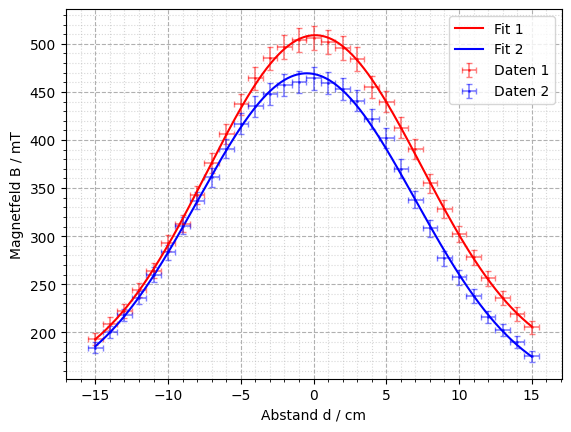

In [10]:
# data kalibration magnetfeld
kal_data1 = np.loadtxt("../data/kal_magnet_ort.txt", skiprows=3)
kal_data2 = np.loadtxt("../data/kal_magnet_ort2.txt", skiprows=3)

# erste kalibration
d1 = kal_data1[:,0]
B1 = kal_data1[:,1]
d1_err = [0.5]*len(d1)
B1_err = np.array([a*0.02+max(B1)*0.005 for a in B1])

# zweite kalibration
d2 = kal_data2[:,0]
B2 = kal_data2[:,1]
d2_err = [0.5]*len(d2)
B2_err = np.array([a*0.02+max(B2)*0.005 for a in B2])

# fit
def gauss(d, B, d_err, B_err):
    
    gauss  = lmfit.models.GaussianModel(prefix='g_')
    linear = lmfit.models.LinearModel(prefix='b_')

    model = gauss + linear

    params = model.make_params()

    # Guess Gaussian
    params.update(gauss.guess(B, x=d))

    # Guess linear background
    params['b_intercept'].set(value=np.min(B))
    params['b_slope'].set(value=0)

    weights = 1.0 / B_err
    result = model.fit(B, params, x=d, weights=weights)
    return result

result1 = gauss(d1, B1, d1_err, B1_err)
result2 = gauss(d2, B2, d2_err, B2_err)
print(result1.fit_report())
print(result2.fit_report())

# plot
d_fit = np.linspace(min(min(d1), min(d2)), max(max(d1), max(d2)), 500)
plt.figure()
plt.errorbar(d1, B1, xerr=d1_err, yerr=B1_err, 
             fmt='r.', label='Daten 1', capsize=2, markersize=2.2, ecolor='red', elinewidth=1.2, alpha=0.5)
plt.errorbar(d2, B2, xerr=d2_err, yerr=B2_err, 
             fmt='b.', label='Daten 2', capsize=2, markersize=2.2, ecolor='blue', elinewidth=1.2, alpha=0.5)
plt.plot(d_fit, result1.eval(x=d_fit), 'r-', label='Fit 1')
plt.plot(d_fit, result2.eval(x=d_fit), 'b-', label='Fit 2')
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.xlabel(r'Abstand d / cm')
plt.ylabel(r'Magnetfeld B / mT')
plt.legend()
plt.show()

Das stellt einen Fit nach dem Modell
\begin{align}
B(d) &= B_{Gauss} + B_{linear}\\
 &= A\cdot\exp\left( -\frac{(d-d_0)^2}{2\sigma^2} \right) + a + bd
\end{align}
dar.

### Extrahiere Werte

In [ ]:
import pandas as pd

def extract_fit(result, label):
    p = result.params
    return {
        "Messung": label,
        "A":        p["g_amplitude"].value,
        "d0":       p["g_center"].value,
        "sigma":    p["g_sigma"].value,
        "a_bg":     p["b_intercept"].value,
        "b_bg":     p["b_slope"].value,
        "dA":       p["g_amplitude"].stderr,
        "dd0":      p["g_center"].stderr,
        "dsigma":   p["g_sigma"].stderr,
        "da_bg":    p["b_intercept"].stderr,
        "db_bg":    p["b_slope"].stderr,
        "redchi":   result.redchi,
    }

rows = [
    extract_fit(result1, "Kalib 1"),
    extract_fit(result2, "Kalib 2"),
]

df = pd.DataFrame(rows)
print(df)
print('=============================')

df_tex = pd.DataFrame({
    "Messung": df["Messung"],
    "$A$ / mT": df.apply(lambda r: f"{r['A']:.3f} \\pm {r['dA']:.3f}", axis=1),
    "$d_0$ / cm": df.apply(lambda r: f"{r['d0']:.3f} \\pm {r['dd0']:.3f}", axis=1),
    r"$\sigma$ / cm": df.apply(lambda r: f"{r['sigma']:.3f} \\pm {r['dsigma']:.3f}", axis=1),
    r"$a_\mathrm{bg}$ / mT": df.apply(lambda r: f"{r['a_bg']:.3f} \\pm {r['da_bg']:.3f}", axis=1),
    r"$b_\mathrm{bg}$ / mT/cm": df.apply(lambda r: f"{r['b_bg']:.3e} \\pm {r['db_bg']:.3e}", axis=1),
    r"$\chi^2_\mathrm{red}$": df.apply(lambda r: f"{r['redchi']:.2f}", axis=1),
})

latex_table = df_tex.to_latex(
    index=False,
    escape=False,   # wichtig, damit \pm, \sigma etc. nicht escaped werden
    column_format="lcccccc"  # nach Geschmack anpassen
)

#column_format = "l" + "S[table-format=2.3(3)]"*5 + "S[table-format=1.2]"
#latex_table = df_tex.to_latex(index=False, escape=False, column_format=column_format)


print(latex_table)


   Messung            A        d0     sigma        a_bg      b_bg          dA  \
0  Kalib 1  6563.732152  0.051730  7.384796  154.369478  0.397765  112.787278   
1  Kalib 2  6241.380773 -0.473233  7.460002  135.608266  0.019221  155.742382   

        dd0    dsigma     da_bg     db_bg    redchi  
0  0.046447  0.077958  3.106509  0.093183  0.101841  
1  0.067317  0.112925  4.259212  0.127802  0.211546  
\begin{tabular}{lS[table-format=2.3(3)]S[table-format=2.3(3)]S[table-format=2.3(3)]S[table-format=2.3(3)]S[table-format=2.3(3)]S[table-format=1.2]}
\toprule
Messung & $A$ / mT & $d_0$ / cm & $\sigma$ / cm & $a_\mathrm{bg}$ / mT & $b_\mathrm{bg}$ / mT/cm & $\chi^2_\mathrm{red}$ \\
\midrule
Kalib 1 & 6563.732 \pm 112.787 & 0.052 \pm 0.046 & 7.385 \pm 0.078 & 154.369 \pm 3.107 & 3.978e-01 \pm 9.318e-02 & 0.10 \\
Kalib 2 & 6241.381 \pm 155.742 & -0.473 \pm 0.067 & 7.460 \pm 0.113 & 135.608 \pm 4.259 & 1.922e-02 \pm 1.278e-01 & 0.21 \\
\bottomrule
\end{tabular}



## Strom

Fit parameters for Daten 1: a=-0.5166589387222839, b=0.09279851604270596, c=109.11953546307343, d=-1.5485800287709564
Fit parameters for Daten 2: a=-0.4548682042269533, b=0.06668984734050468, c=104.85971932685612, d=13.821046146803218
======DataFrame und Latex======
     Kalibrierung         a     a_err         b     b_err           c  \
0  Kalibrierung 1 -0.516659  0.015120  0.092799  0.062180  109.119535   
1  Kalibrierung 2 -0.454868  0.015527  0.066690  0.067248  104.859719   

      c_err          d     d_err  
0  0.766041  -1.548580  1.419801  
1  0.764989  13.821046  1.424973  
\begin{tabular}{lrrrrrrrr}
\toprule
Kalibrierung & a & a_err & b & b_err & c & c_err & d & d_err \\
\midrule
Kalibrierung 1 & -0.517 & 0.015 & 0.093 & 0.062 & 109.120 & 0.766 & -1.549 & 1.420 \\
Kalibrierung 2 & -0.455 & 0.016 & 0.067 & 0.067 & 104.860 & 0.765 & 13.821 & 1.425 \\
\bottomrule
\end{tabular}

======Plots und Fits======


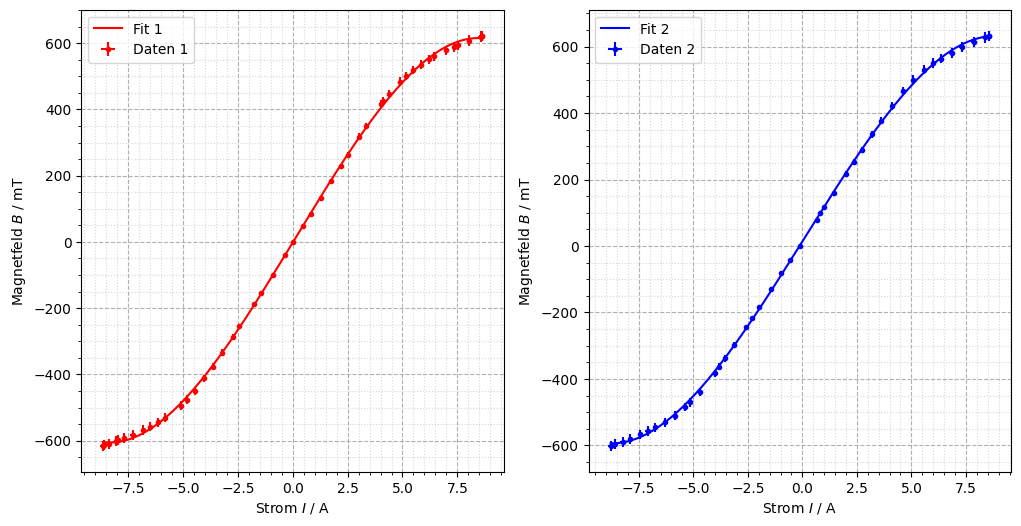

In [20]:
# data kalibration magnetfeld strom
kal_strom_data1 = np.loadtxt("../data/zeeman/Kalibration_01.txt", skiprows=2, delimiter=';')
kal_strom_data2 = np.loadtxt("../data/zeeman/Kalibration_02.txt", skiprows=2, delimiter=';')


I1 = kal_strom_data1[:,0]*-1
I1_err = np.array([a*0.015 for a in np.abs(I1)])
B1_strom = kal_strom_data1[:,1]
B1_strom_err = np.array([a*0.02+max(B1_strom)*0.005 for a in np.abs(B1_strom)])

I2 = kal_strom_data2[:,0]*-1
I2_err = np.array([a*0.015 for a in np.abs(I2)])
B2_strom = kal_strom_data2[:,1]
B2_strom_err = np.array([a*0.02+max(B2_strom)*0.005 for a in np.abs(B2_strom)])

# fit 
def func(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

x_arr1 = I1
x_err1 = I1_err
y_arr1 = B1_strom
y_err1 = B1_strom_err
popt1, pcov1 = curve_fit(func, x_arr1, y_arr1, sigma=y_err1, absolute_sigma=True)
a1, b1, c1, d1 = popt1
print(f"Fit parameters for Daten 1: a={a1}, b={b1}, c={c1}, d={d1}")

x_arr2 = I2
x_err2 = I2_err
y_arr2 = B2_strom
y_err2 = B2_strom_err
popt2, pcov2 = curve_fit(func, x_arr2, y_arr2, sigma=y_err2, absolute_sigma=True)
a2, b2, c2, d2 = popt2
print(f"Fit parameters for Daten 2: a={a2}, b={b2}, c={c2}, d={d2}")

# Fitparameter in DataFrame speichern
print("======DataFrame und Latex======")
df = pd.DataFrame({
    'Kalibrierung': ['Kalibrierung 1', 'Kalibrierung 2'],
    'a': [a1, a2],
    'a_err': [np.sqrt(pcov1[0][0]), np.sqrt(pcov2[0][0])],
    'b': [b1, b2],
    'b_err': [np.sqrt(pcov1[1][1]), np.sqrt(pcov2[1][1])],
    'c': [c1, c2],
    'c_err': [np.sqrt(pcov1[2][2]), np.sqrt(pcov2[2][2])],
    'd': [d1, d2],
    'd_err': [np.sqrt(pcov1[3][3]), np.sqrt(pcov2[3][3])],
})
print(df)
# Latex Tabelle
latex_table = df.to_latex(index=False, float_format="%.3f", escape=False)
print(latex_table)    

print("======Plots und Fits======")
x_fit1 = np.linspace(np.min(I1), np.max(I1), 500)
x_fit2 = np.linspace(np.min(I2), np.max(I2), 500)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].errorbar(I1, B1_strom, xerr=I1_err, yerr=B1_strom_err, fmt='r.', label='Daten 1', capsize=0)
ax[0].plot(x_fit1, func(x_fit1, *popt1), 'r-', label='Fit 1')
ax[0].grid(visible=True, which="major", linestyle="--")
ax[0].minorticks_on()
ax[0].grid(visible=True, which="minor", linestyle=":", alpha=0.5)
ax[0].set_xlabel(r'Strom $I$ / A')
ax[0].set_ylabel(r'Magnetfeld $B$ / mT')
ax[0].legend()

ax[1].errorbar(I2, B2_strom, xerr=I2_err, yerr=B2_strom_err, fmt='b.', label='Daten 2', capsize=0)
ax[1].plot(x_fit2, func(x_fit2, *popt2), 'b-', label='Fit 2')
ax[1].grid(visible=True, which="major", linestyle="--")
ax[1].minorticks_on()
ax[1].grid(visible=True, which="minor", linestyle=":", alpha=0.5)
ax[1].set_xlabel(r'Strom $I$ / A')
ax[1].set_ylabel(r'Magnetfeld $B$ / mT')
ax[1].legend()
plt.show()

### Gesamtanpassung

popt_new = array([-4.85763571e-01,  7.97441817e-02,  1.06989627e+02,  6.13623306e+00])
pcov_new = array([[ 9.07627021e-34,  2.31445275e-34, -4.14118675e-32,
        -3.52113313e-33],
       [ 2.31445275e-34,  1.78149162e-32, -7.54154088e-33,
        -4.51063467e-31],
       [-4.14118675e-32, -7.54154088e-33,  2.25022368e-30,
         1.14748549e-31],
       [-3.52113313e-33, -4.51063467e-31,  1.14748549e-31,
         2.05648647e-29]])
-------------
popt1 = array([-5.16658939e-01,  9.27985160e-02,  1.09119535e+02, -1.54858003e+00])
pcov1 = array([[ 2.28617404e-04,  2.37463113e-05, -1.02402752e-02,
         5.72444771e-04],
       [ 2.37463113e-05,  3.86634967e-03, -3.45610329e-04,
        -4.49529023e-02],
       [-1.02402752e-02, -3.45610329e-04,  5.86818327e-01,
        -3.99914633e-02],
       [ 5.72444771e-04, -4.49529023e-02, -3.99914633e-02,
         2.01583487e+00]])
popt2 = array([-4.54868204e-01,  6.66898473e-02,  1.04859719e+02,  1.38210461e+01])
pcov2 = array([[ 2.41085992e-0

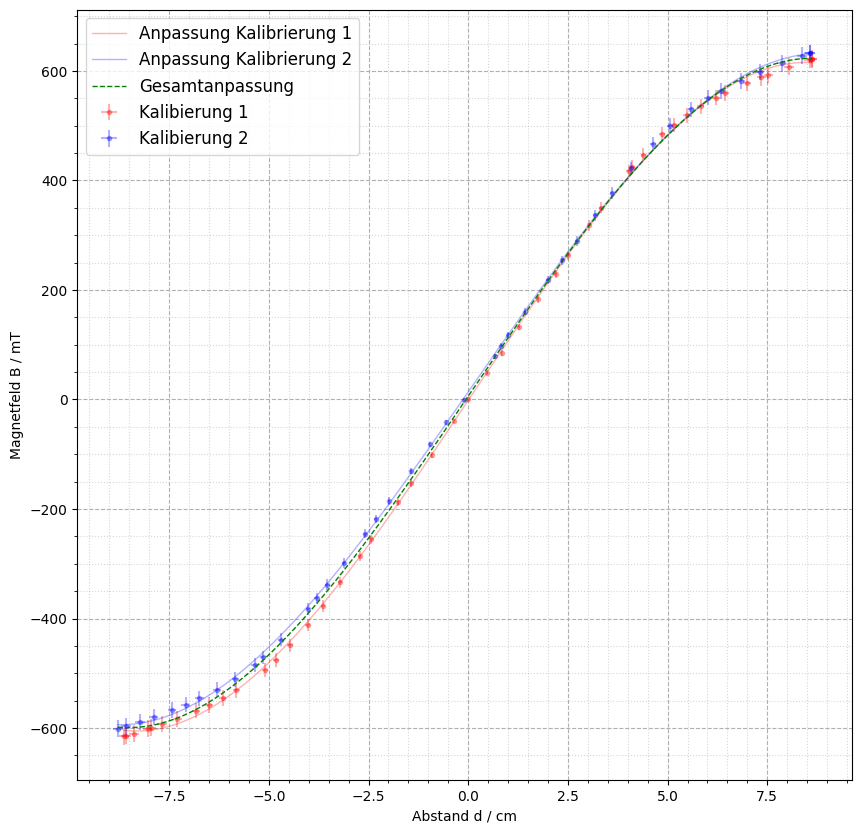

In [30]:
# Plot und Fit mit Gesamtanpassung
x_bar = np.linspace(min(min(I1), min(I2)), max(max(I1), max(I2)), 500)
y_bar = (func(x_bar, *popt1) + func(x_bar, *popt2)) / 2
popt_new = curve_fit(func, x_bar, y_bar)[0]
pcov_new = curve_fit(func, x_bar, y_bar)[1]
print(f'{popt_new = }')
print(f'{pcov_new = }')
print('-------------')
print(f'{popt1 = }')
print(f'{pcov1 = }')
print(f'{popt2 = }')
print(f'{pcov2 = }')
print('======Gesamtanpassung======')
print(f"Fit parameters for Gesamtanpassung: a={popt_new[0]}, b={popt_new[1]}, c={popt_new[2]}, d={popt_new[3]}")
print(f'Fit parameter errors: a_err={np.sqrt(pcov_new[0][0])}, b_err={np.sqrt(pcov_new[1][1])}, c_err={np.sqrt(pcov_new[2][2])}, d_err={np.sqrt(pcov_new[3][3])}')
df_total = pd.DataFrame({
    'Gesamtanpassung': ['Gesamtanpassung'],
    'a': [popt_new[0]],
    'a_err': [np.sqrt(pcov_new[0][0])],
    'b': [popt_new[1]],
    'b_err': [np.sqrt(pcov_new[1][1])],
    'c': [popt_new[2]],
    'c_err': [np.sqrt(pcov_new[2][2])],
    'd': [popt_new[3]],
    'd_err': [np.sqrt(pcov_new[3][3])],
})
print(df_total)
latex_table_total = df_total.to_latex(index=False, float_format="%.3f", escape=False)
print(latex_table_total)

# plot
d_fit = np.linspace(min(min(I1), min(I2)), max(max(I1), max(I2)), 500)
plt.figure(figsize=(10,10))
plt.errorbar(I1, B1_strom, xerr=I1_err, yerr=B1_strom_err, fmt='r.', label='Kalibierung 1', capsize=0, alpha=0.3)
plt.plot(x_fit1, func(x_fit1, *popt1), 'r-', label='Anpassung Kalibrierung 1', alpha=0.3, linewidth=1)
plt.errorbar(I2, B2_strom, xerr=I2_err, yerr=B2_strom_err, fmt='b.', label='Kalibierung 2', capsize=0, alpha=0.3)
plt.plot(x_fit2, func(x_fit2, *popt2), 'b-', label='Anpassung Kalibrierung 2', alpha=0.3, linewidth=1)
plt.plot(x_bar, y_bar, 'g--', label='Gesamtanpassung', linewidth=1, zorder=3)
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.xlabel(r'Abstand d / cm')
plt.ylabel(r'Magnetfeld B / mT')
plt.legend(fontsize=12)
plt.show()